# Systemy uczące się - Zad. dom. 2: Naiwny klassyfikator Bayesa

### Autor rozwiązania
Uzupełnij poniższe informacje umieszczając swoje imię i nazwisko oraz numer indeksu:


In [1]:
NAME = "Mikołaj Nowak"
ID = "151813"

Ten notebook zawiera dwa zadania związane z klasyfikatorem naiwnego Bayesa, oprócz implementacji zawiera on równie pytania na które trzeba odpowiedzieć.

## Zadanie 1
Zadanie polega na implementacji klasyfikatora naiwnego Bayesa dla zmiennych ciągłych gdzie za rozkłady cechy przyjmij rozkłady normalne.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.style.use("ggplot")

Do testowania twojego rozwiązania użyj trzech generatorów danych sztucznych `generate1`, `generate2` oraz `generate3` (funkcje te przyjmują jako argument liczbę elementów do wygenerowania z każdej klasy - domyślnie $N=100$). Sposób ich wywołania jest przedstawiony poniżej:

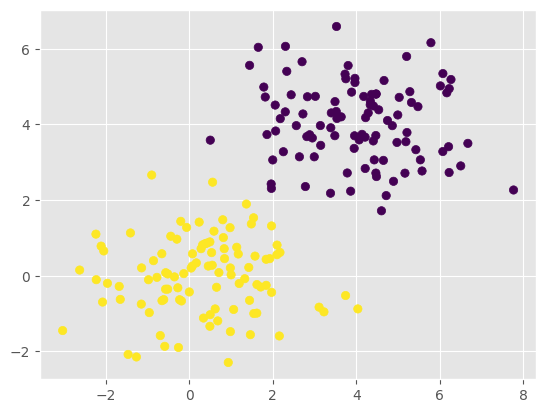

In [3]:
from helpers import generate1, generate2, generate3  # noqa

x, y = generate1()
plt.scatter(x[:, 0], x[:, 1], c=y)

W implementacji będzie przydatna klasa `norm` z pakietu `scipy`, która zwraca wartości funkcji gęstości prawdopodobieństwa rozkładu normalnego dla zmiennych ciągłych.

In [4]:
from scipy.stats import norm

# (x, mean, std)
norm.pdf(5, 0, 1)  # gęstość prawd. dla 5 z rozkładu standardowego
norm.logpdf(5, 0, 1)  # logarytm gęstości prawd. dla 5 z rozkładu standardowego

-13.418938533204672

Zaimplementuj klasyfikator naiwnego Bayesa dla zmiennych ciągłych. Pamiętaj o zabezpieczniu się przed problemem wynikającym z mnożenia wielu małych liczb (prawdopodobieństw).

In [5]:
class GaussianNaiveBayes():
    def __init__(self) -> None:
        self.means = {}
        # Słownik, który docelowo powinien zawierać tablicę/wektor warunkowych średnich dla każdego atrybutu 
        # Każda tablica/wektor powinna być typu np.array
        # np. 1) means[1] powinno zawierać wektor średnich wartości atrybutów  dla klasy o indeksie 1
        #     2) means[0][1] powinno zawierać średnią 1 atrybutu dla klasy o indeksie 0
        # (Możesz spróbować zaimplementować efektywniejszą implementację używając macierzy)
        self.stds = {}
        # Analogiczna struktura dla odchyleń standardowych
        self.class_log_prob = None
        # Wektor zawierający logarytmy prawdopodobieństwa dla każdej z klas 
        # np. class_log_prob[1] zawiera logarytm prawdopodobieństwa, że klasa jest równa 1 P(C=1)
        self.classes = None

    def fit(self, x: np.ndarray, y: np.ndarray) -> None:
        """Funkcja trenująca klasyfikator naiwnego Bayesa na podstawie danych x i y.
        
        Args:
            x (np.ndarray): macierz danych wejściowych, gdzie każdy wiersz to obserwacja
            y (np.ndarray): wektor indeksów klas (0 lub 1) dla każdej obserwacji
            
        Returns:
            None
        """
        self.classes = set(y)
        self.means = [np.mean(x[y == cls,:], axis=0) for cls in self.classes]
        self.stds = [np.std(x[y == cls,:], axis=0) for cls in self.classes]
        self.class_log_prob = np.log([np.mean(y == cls) for cls in self.classes])

    def predict_proba(self, x: np.ndarray) -> np.ndarray:
        """Funkcja zwracająca prawdopodobieństwa przynależności do klas dla każdej obserwacji w macierzy x.
        
        Args:
            x (np.ndarray): macierz danych wejściowych, gdzie każdy wiersz to obserwacja
        
        Returns:
            np.ndarray: macierz o dwóch kolumnach (dwie klasy) w której kolejne wiersze  zawierają prawdopodobieństwa P(c|x) 
                przynależności dla klas dla kolejnych obserwacji w macierzy x
        
        """
        # PDF stands for probability density function
        # Probabilities are often very small, so we take the logarithm to avoid numerical underflow
        (examples, features) = x.shape
        return np.exp([
            [
                sum(norm.logpdf(x[example][feature], self.means[cls][feature], self.stds[cls][feature]) for feature in range(features)) + self.class_log_prob[cls]
                for cls in self.classes
            ] for example in range(examples)
        ])

    def predict(self, x: np.ndarray) -> np.ndarray:
        # Gotowa funkcja wybierająca klasę z największym prawdopodobieństwem
        prob = self.predict_proba(x)
        return np.argmax(prob, axis=1)


Przetestuj twój klasyfikator na wygenerowanych wcześniej danych.

In [6]:
gnb = GaussianNaiveBayes()
gnb.fit(x, y)

# Trafność na zbiorze uczącym
np.mean(gnb.predict(x) == y)

1.0

Narysowanie nauczonego klasyfikatora

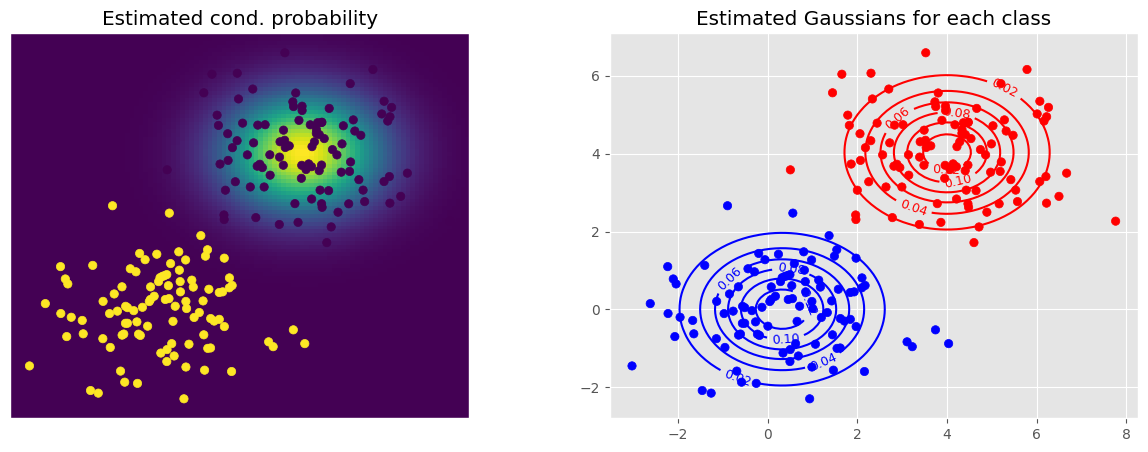

In [7]:
from helpers import plot_gaussian_bayes

plot_gaussian_bayes(x, y, gnb)

Użyj funkcji do generowania danych, aby wygenerować zbiór testowy oraz sprawdź na nim trafność klasyfikacji metody.

In [8]:
x_test, y_test = generate1(1000)
np.mean(gnb.predict(x_test) == y_test)

0.993

**Ćwiczenia**
 - Pamiętaj o przetestowaniu Twojego algorytmu dla wszystkich trzech generatorów danych. W których ze zbiorów założenie o warunkowej niezależności zmiennych jest spełnione? Jak brak spełnienia tego założenia wpływa na działanie klasyfikatora?
 - Z pliku `helpers` zaimportuj klasę `GaussianBayes` (identyczna obsługa jak tej zaimplementowanej przez Ciebie). Klasa implementuje algorytm Bayesa bez założenia o niezależności zmiennych (ale z założeniem o normalności rozkładów). Porównaj wyniki - szczególnie dla zbiorów dla których założenie o warunkowej niezależności zmiennych nie jest spełnione.
 - Klasyfikatora `GaussianBayes` nie można wytrenować na zbiorach które mają mniej niż 3 przykłady dla każdej z klas. Jak myślisz dlaczego? Jak ten problem będzie się zmieniał dla zbiorów o wysokiej liczbie cech?
 - Nawet używając klasyfikatora `GaussianBayes`, który zakłada kompletny model zależności i prawidłowy rozkład danych (nasze dane są generowane z rozkładów normalnych) - często nie jest w stanie uzyskać 100% trafności nawet na zbiorze uczącym. Jak myślisz, dlaczego? 
 - Czy gdyby przepisać do klasyfikatora prawdziwe wartości średnich i macierz wariancji-kowariancji cech (z generatora) - uzyskalibyśmy 100% trafność? Co możemy powiedzieć o takim klasyfikatorze? Czy jest możliwe uzyskanie klasyfikatora bardziej trafnego niż taki? 
 
 Odpowiedzi na dwa ostatnie pytania zostaną sprawdzone: wpisz swoje odpowiedzi poniżej.

4. Klasyfikator Bayesowski zwraca prawdopodobieństwa przynależności do danej klasy, zatem przy danym prawdopodobieństwie `p` prognozowany błąd wynosi `1-p`, gdyż jeśli przypadków testwych jest dostatecznie dużo, to z pewnością wygeneruje się przypadek w obszarze, gdzie przewaga będzie po stronie innej klasy, co obniży trafność modelu. Dodatkowo granica między klasami bywa mniej wyraźna (jak w przykładzie 3), gdy wartości średnich i odchylek standardowych rozkładów dla różnych klas będą do siebie zbliżone.

5. Klasyfikator Bayesowski nie osiągnie 100% trafności, ponieważ generator może z niezerowym prawdopodobieństwem wygenerować dane, które są nietypowe dla danej klasy. Klasyfikator o 100% trafności byłby klasyfikatorem doskonałym, który zawsze poprawnie przypisuje klasę każdemu przykładowi w populacji: jest odporny na szum, błędy i takie przypadki, jakie zostały opisane w poprzednim punkcie. W ogólności nie istnieje taki klasyfikator. Niemniej jednak, klasyfikator Bayesowski, który ma pełną wiedzę o parametrach procesu generującego dane, jest optymalny – oznacza to, że mimo pewnych niedoskonałości, nie istnieje model, który byłby bardziej trafny w tym przypadku.


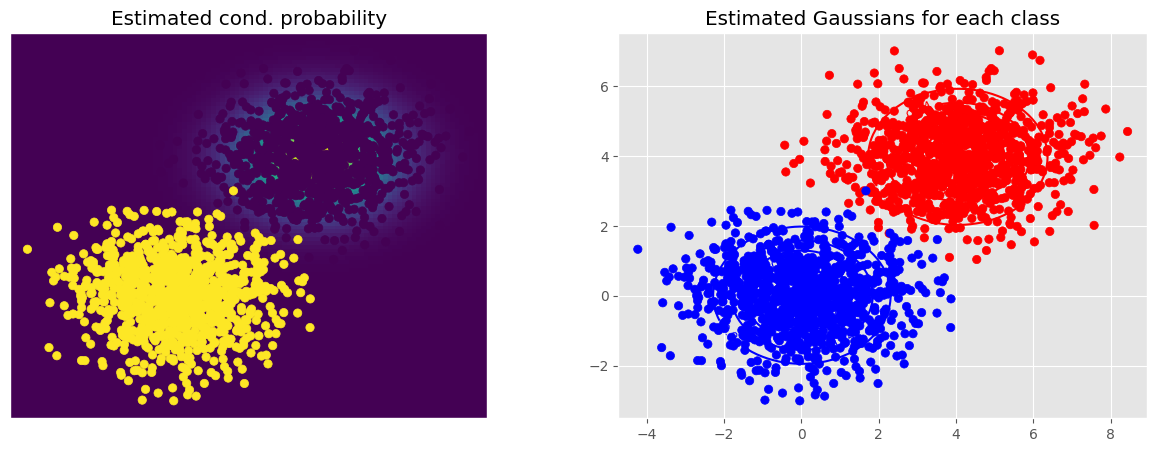

Naïve Bayes accuracy: 0.995


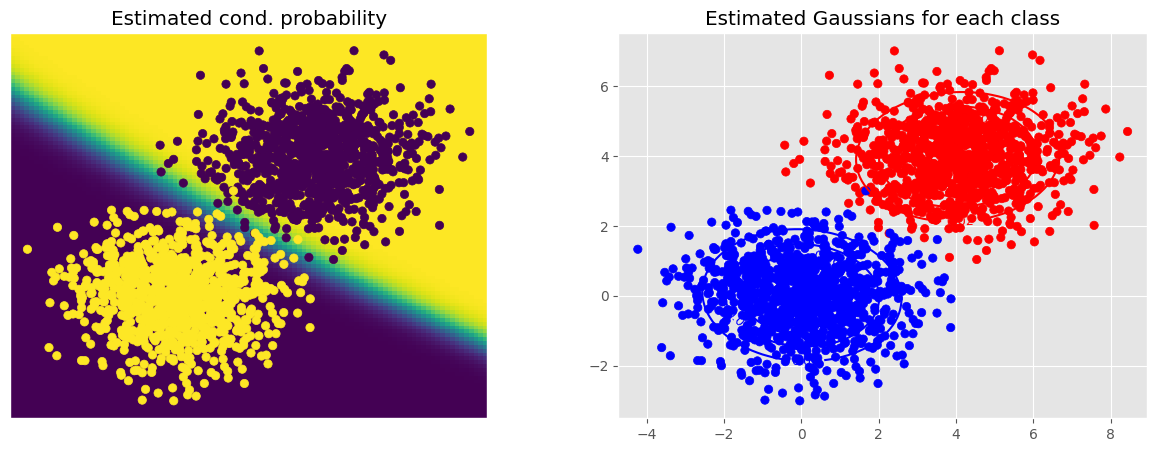

Gaussian Bayes accuracy: 0.994


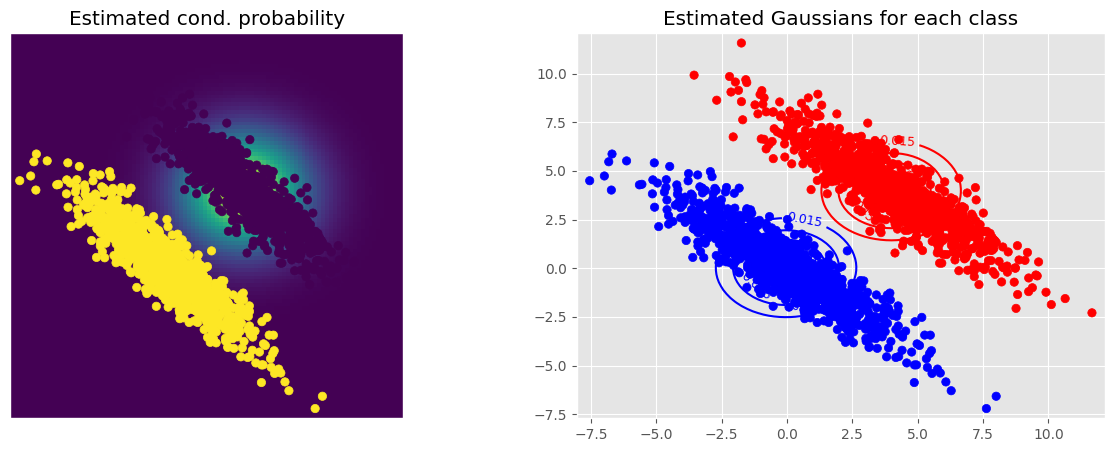

Naïve Bayes accuracy: 1.0


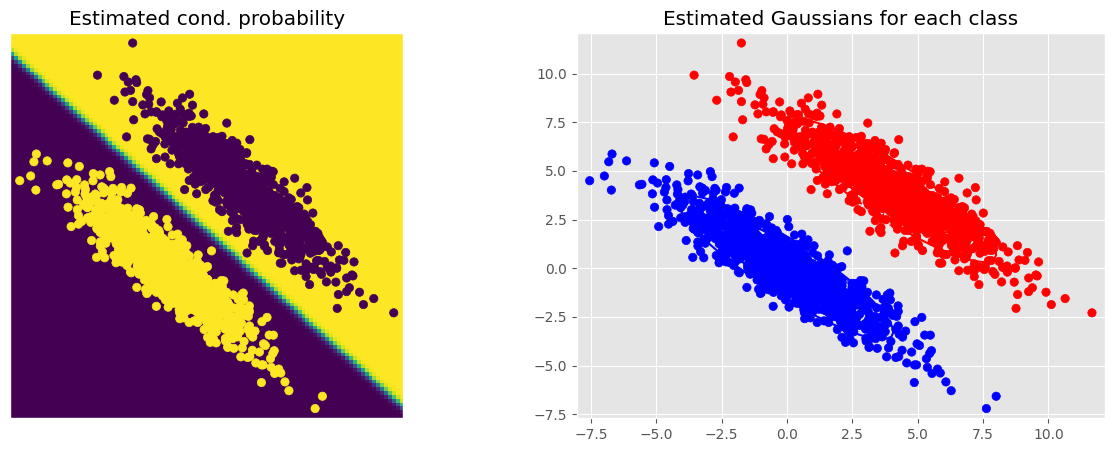

Gaussian Bayes accuracy: 1.0


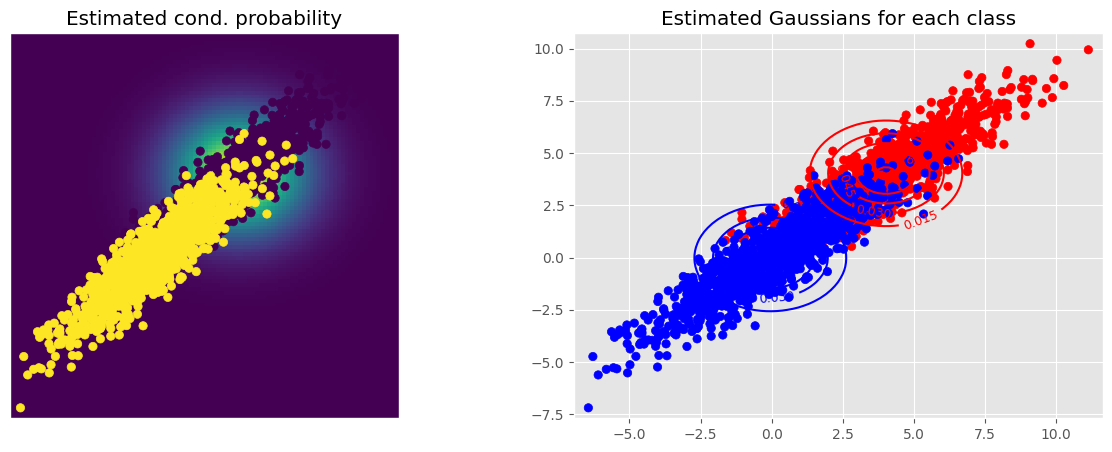

Naïve Bayes accuracy: 0.8255


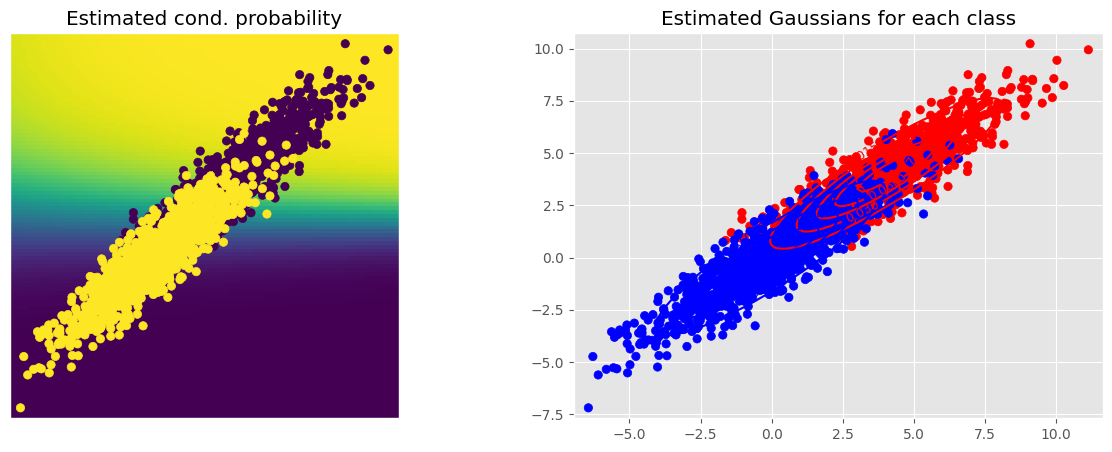

Gaussian Bayes accuracy: 0.837


In [9]:
from helpers import GaussianBayes

datasets = [generate1, generate2, generate3]

for generate in datasets:
    x_train, y_train = generate(1000)
    
    # Naïve Bayes
    gnb.fit(x_train, y_train)
    plot_gaussian_bayes(x_train, y_train, gnb)
    x_test, y_test = generate(1000)
    print(f"Naïve Bayes accuracy: {np.mean(gnb.predict(x_test) == y_test)}")
    
    # GaussianBayes
    g_bayes = GaussianBayes()
    g_bayes.fit(x_train, y_train)
    plot_gaussian_bayes(x_train, y_train, g_bayes)
    print(f"Gaussian Bayes accuracy: {np.mean(g_bayes.predict(x_test) == y_test)}")

# Zadanie 2
Klasyfikator naiwnego Bayesa często jest używany do klasyfikacji tekstów. Przetestuj działanie algorytmów na podanym rzeczywistym zbiorze danych: 
> The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon a messages posted before and after a specific date.

Podany zbiór jest wieloklasowy, więc poniższy kod wybiera z niego podzbiór postów tylko z dwóch tematów.

In [10]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

categories = ['comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)

vectorizer = TfidfVectorizer(binary=True, use_idf=False, norm=None)  # Przekształcenie tekstu na cechy binarne
vectors = vectorizer.fit_transform(newsgroups_train.data)
vectors_test = vectorizer.transform(newsgroups_test.data)
vectors = vectors.toarray()
vectors_test = vectors_test.toarray()

Dokumenty w zbiorze można wyświetlić w następujący sposób.

In [11]:
newsgroups_train.data[0:3]

['From: ab@nova.cc.purdue.edu (Allen B)\nSubject: Re: thining algorithm\nOrganization: Purdue University\nLines: 15\n\nIn article <1q7615INNmi@shelley.u.washington.edu> kshin@stein.u.washington.edu  \n(Kevin Shin) writes:\n> I am trying obtain program to preprocess handwriting characters.\n> Like thining algorithm, graph alogrithm.\n> Do anyone know where I can obtain those?\n\nI usually use "Algorithms for graphics and image processing" by\nTheodosios Pavlidis, but other people here got them same idea and now\n3 of 4 copies in the libraries have been stolen!\n\nAnother reference is "Digital Image Processing" by Gonzalez and\nWintz/Wood, which is widely available but a little expensive ($55\nhere- I just checked today).\n\nab\n',
 "From: stephens@geod.emr.ca (Dave Stephenson)\nSubject: Re: Clementine Science Team Selected\nNntp-Posting-Host: ngis.geod.emr.ca\nOrganization: Dept. of Energy, Mines, and Resources, Ottawa\nLines: 32\n\nnickh@CS.CMU.EDU (Nick Haines) writes:\n\n>In article 

Analogicznie możemy uzyskać dostęp do informacji o klasach.

In [12]:
newsgroups_train.target[0:3]

array([0, 1, 0], dtype=int64)

i do "zbinaryzowanego" tekstu

In [13]:
vectors[0:3]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Wytrenuj klasyfikator Naiwnego Bayesa z rozmywaniem estymat (patrz pakiet `sklearn`) i sprawdż jego trafność na zbiorze uczącym i testowym.

In [14]:
from sklearn.metrics import accuracy_score

class NaiveBayesWithSmoothing:
    def __init__(self, alpha=1.0):
        self.alpha = alpha  # Smoothing parameter

    def fit(self, X, y):
        """Trains the Naive Bayes classifier with smoothing estimates."""
        self.classes = np.unique(y)
        self.class_prob = np.zeros(len(self.classes))  # Class probabilities
        self.feature_prob = {}  # Feature probabilities for each class

        # Compute class probabilities
        for cls in self.classes:
            self.class_prob[cls] = np.mean(y == cls)
        
        # Compute feature probabilities with smoothing
        for c in self.classes:
            X_c = X[y == c]  # Select only observations for class c
            # Smoothed estimate for feature probabilities:
            # P(X_i | class) = (sum(X_c_i) + alpha) / (n_c + 2 * alpha)
            # where:
            # - sum(X_c_i) is the number of occurances of feature i for all samples in class c,
            # - n_c is the number of samples in class c,
            # - alpha is the smoothing parameter.
            feature_prob_c = (np.sum(X_c, axis=0) + self.alpha) / (X_c.shape[0] + 2 * self.alpha)  # Smoothed estimate
            self.feature_prob[c] = feature_prob_c

    def predict(self, X):
        """Makes predictions on new data."""
        log_probs = []

        for cls in self.classes:
            # Log P(k) for class c
            log_class_prob = np.log(self.class_prob[cls])
            # Log P(X|c) - sum of log P(X_i|c) for features
            log_feature_prob = np.sum(np.log(self.feature_prob[cls]) * X + np.log(1 - self.feature_prob[cls]) * (1 - X), axis=1)
            log_probs.append(log_class_prob + log_feature_prob)

        # Predict the class with the highest log probability
        return self.classes[np.argmax(log_probs, axis=0)]

# Create the Naive Bayes classifier with smoothing estimates
nb_classifier = NaiveBayesWithSmoothing(alpha=1.0)

# Train the classifier
nb_classifier.fit(vectors, newsgroups_train.target)

# Evaluate on the training set
train_pred = nb_classifier.predict(vectors)
train_accuracy = accuracy_score(newsgroups_train.target, train_pred)
print(f'Training set accuracy: {train_accuracy:.4f}')

# Evaluate on the test set
test_pred = nb_classifier.predict(vectors_test)
test_accuracy = accuracy_score(newsgroups_test.target, test_pred)
print(f'Test set accuracy: {test_accuracy:.4f}')


Training set accuracy: 0.9405
Test set accuracy: 0.8672


**Ćwiczenia**
 - Dlaczego klasyfikator Naiwnego Bayesa dość dobrze sprawdza się do powyższego zadania i analogicznych?
 - Przeanalizuj wartości estymat prawdopodobieństw. Które cechy/słowa są najlepszymi wskaźnikami dla podanych klas? Jakie słowa bardzo słabo wskazują na którąkolwiek z klas?
 - Czy byłoby możliwe wytrenowanie równie skutecznego klasyfikatora z mniejszą liczbą cech? W jaki sposób można by to uzyskać?
 - Analizowany zbiór jest oryginalnie wieloklasowy z tego powodu możemy go wykorzystać do wielu testów wybierając różne pary klas. Pełna lista tematów: 'alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc'
 - Czy są pary tematów dla których ten klasyfikator działa znacząco gorzej?
 - Jakie są zalety stosowania klasyfikatora Bayesa dla tego problemu (i w ogólności)? Czy do tego problemu sprawdziłyby się reguły lub drzewa decyzyjne? Dlaczego?
 
 Odpowiedzi na kropki 1, 3 i 6 wpisz poniżej - zostaną sprawdzone.

- Klasyfikator Bayesa dobrze działa w klasyfikacji tekstu, ponieważ zakłada niezależność cech (słów), co upraszcza obliczenia. Jest szybki, skuteczny i sprawdza się w zadaniach z dużymi zbiorami danych.

- Tak, możliwe. Można zastosować selekcję cech (np. TF-IDF) lub algorytmy redukcji wymiarowości, jak PCA, aby zmniejszyć liczbę cech i zachować najistotniejsze informacje.

- Zaletą Bayesa jest szybkość, skalowalność i łatwa interpretowalność. Drzewa decyzyjne mogą być podatne na przeuczenie, a reguły mniej skuteczne w zadaniach z dużą liczbą cech, jak klasyfikacja tekstu.


In [15]:
def find_worst_class_pairs(classes):
    """
    This function evaluates the accuracy of the Naive Bayes classifier on all pairs of classes
    and returns the pair of classes where the classifier performs the worst.
    
    Parameters:
    - classes: A list of class labels.
    
    Returns:
    - best_pair: The pair of classes where the classifier performs the worst.
    - worst_accuracy: The worst accuracy for the pair.
    """
    worst_accuracy = 1.0
    worst_pair = None
    
    for i in range (len(classes)):
        for j in range (i+1, len(classes)):
            categories = [classes[i], classes[j]]
            newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
            newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)

            vectorizer = TfidfVectorizer(binary=True, use_idf=False, norm=None)  # Przekształcenie tekstu na cechy binarne
            vectors = vectorizer.fit_transform(newsgroups_train.data)
            vectors_test = vectorizer.transform(newsgroups_test.data)
            vectors = vectors.toarray()
            vectors_test = vectors_test.toarray()

            # Create the Naive Bayes classifier with smoothing estimates
            nb_classifier = NaiveBayesWithSmoothing(alpha=1.0)

            # Train the classifier
            nb_classifier.fit(vectors, newsgroups_train.target)

            # Evaluate on the test set
            test_pred = nb_classifier.predict(vectors_test)
            test_accuracy = accuracy_score(newsgroups_test.target, test_pred)
            
            # Update if this is the worst accuracy encountered
            if test_accuracy < worst_accuracy:
                worst_accuracy = test_accuracy
                worst_pair = (classes[i], classes[j])
    
    return worst_pair, worst_accuracy

# List of topic classes
classes = [
    'alt.atheism',
    'comp.graphics',
    'comp.os.ms-windows.misc',
    'comp.sys.ibm.pc.hardware',
    'comp.sys.mac.hardware',
    'comp.windows.x',
    'misc.forsale',
    'rec.autos',
    'rec.motorcycles',
    'rec.sport.baseball',
    'rec.sport.hockey',
    'sci.crypt',
    'sci.electronics',
    'sci.med',
    'sci.space',
    'soc.religion.christian',
    'talk.politics.guns',
    'talk.politics.mideast',
    'talk.politics.misc',
    'talk.religion.misc'
]

worst_pair, worst_accuracy = find_worst_class_pairs(classes)
print(f'Worst pair of topics: {worst_pair}')
print(f'Accuracy for this pair: {worst_accuracy:.4f}')


Worst pair of topics: ('comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware')
Accuracy for this pair: 0.5013
